# 5DOF Cart-Pole System Model - Position

Theoretical mathematical model of the 4DOF cart-pole system in the coordinate system $ (x, y, z, \theta, \varphi) $ with external normal velocity as free variable.

Dynamic model uses Euler-Lagrange equations.

Prefixes:
- cs: coordinate system
- fn: function
- fv: free variable
- l: lagrangian/energy
- p: point

In [1]:
import importlib.util
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from IPython.display import display, Math, Latex
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from scipy.optimize import lsq_linear, minimize

In [2]:
class StateXyz:
    _map = {
        'x': (0, 'X'), 'y': (1, 'X'), 'z': (2, 'X'),
        'xd': (0, 'Xd'), 'yd': (1, 'Xd'), 'zd': (2, 'Xd'),
        'xdd': (0, 'Xdd'), 'ydd': (1, 'Xdd'), 'zdd': (2, 'Xdd')
    }

    def __init__(self, name, X=None, Xd=None, Xdd=None):
        self._name = name
        self.X = X
        self.Xd = Xd
        self.Xdd = Xdd
        self._X_norm = self._Xd_norm = self._Xdd_norm = None

    def __getattr__(self, key):
        if key in self._map:
            idx, attr = self._map[key]
            val = getattr(self, attr)
            if val is not None:
                return val[idx]
            raise AttributeError(f"{attr} is None for key '{key}'")
        raise AttributeError(f"{key} not found")

    def __setattr__(self, key, value):
        if key in {'_name', 'X', 'Xd', 'Xdd', '_X_norm', '_Xd_norm', '_Xdd_norm'}:
            super().__setattr__(key, value)
        elif key in self._map:
            idx, attr = self._map[key]
            array = getattr(self, attr)
            if array is not None:
                array[idx] = value
            else:
                raise AttributeError(f"{attr} is None, cannot assign '{key}'")
        else:
            super().__setattr__(key, value)

    @property
    def X_norm(self):
        if self._X_norm is None and self.X is not None:
            return sp.sqrt(self.X.dot(self.X))
        return self._X_norm

    @X_norm.setter
    def X_norm(self, value):
        self._X_norm = value

    @property
    def Xd_norm(self):
        if self._Xd_norm is None and self.Xd is not None:
            return sp.sqrt(self.Xd.dot(self.Xd))
        return self._Xd_norm

    @Xd_norm.setter
    def Xd_norm(self, value):
        self._Xd_norm = value

    @property
    def Xdd_norm(self):
        if self._Xdd_norm is None and self.Xdd is not None:
            return sp.sqrt(self.Xdd.dot(self.Xdd))
        return self._Xdd_norm

    @Xdd_norm.setter
    def Xdd_norm(self, value):
        self._Xdd_norm = value

    def diff(self, wrt):
        if self.X is not None:
            self.Xd = self.X.diff(wrt)

    def diff2(self, wrt):
        if self.Xd is not None:
            self.Xdd = self.Xd.diff(wrt)


class StateGen:
    _map = {
        'x': (0, 'Q'), 'y': (1, 'Q'), 'z': (2, 'Q'), 't': (3, 'Q'), 'p': (4, 'Q'),
        'xd': (0, 'Qd'), 'yd': (1, 'Qd'), 'zd': (2, 'Qd'), 'td': (3, 'Qd'), 'pd': (4, 'Qd'),
        'xdd': (0, 'Qdd'), 'ydd': (1, 'Qdd'), 'zdd': (2, 'Qdd'), 'tdd': (3, 'Qdd'), 'pdd': (4, 'Qdd')
    }

    def __init__(self, name, Q=None, Qd=None, Qdd=None):
        self._name = name

        if Q is None:
            self.Q = sp.Matrix([
                sp.Symbol(r'x_{' + name + '}'),
                sp.Symbol(r'y_{' + name + '}'),
                sp.Symbol(r'z_{' + name + '}'),
                sp.Symbol(r'\theta_{' + name + '}'),
                sp.Symbol(r'\phi_{' + name + '}')
            ])
        elif isinstance(Q, sp.Matrix):
            self.Q = Q
        else:
            raise TypeError(f"Q must be a Matrix, not {type(Q)}")

        if Qd is None:
            self.Qd = sp.Matrix([
                sp.Symbol(r'\dot{x}_{' + name + '}'),
                sp.Symbol(r'\dot{y}_{' + name + '}'),
                sp.Symbol(r'\dot{z}_{' + name + '}'),
                sp.Symbol(r'\dot{\theta}_{' + name + '}'),
                sp.Symbol(r'\dot{\phi}_{' + name + '}')
            ])
        elif isinstance(Qd, sp.Matrix):
            self.Qd = Qd
        else:
            raise TypeError(f"Qd must be a Matrix, not {type(Qd)}")

        if Qdd is None:
            self.Qdd = sp.Matrix([
                sp.Symbol(r'\ddot{x}_{' + name + '}'),
                sp.Symbol(r'\ddot{y}_{' + name + '}'),
                sp.Symbol(r'\ddot{z}_{' + name + '}'),
                sp.Symbol(r'\ddot{\theta}_{' + name + '}'),
                sp.Symbol(r'\ddot{\phi}_{' + name + '}')
            ])
        elif isinstance(Qdd, sp.Matrix):
            self.Qdd = Qdd
        else:
            raise TypeError(f"Qdd must be a Matrix, not {type(Qdd)}")

        self._Q_norm = self._Qd_norm = self._Qdd_norm = None

    def __getattr__(self, key):
        if key in self._map:
            idx, attr = self._map[key]
            val = getattr(self, attr)
            if val is not None:
                return val[idx]
            raise AttributeError(f"{attr} is None for key '{key}'")
        raise AttributeError(f"{key} not found")

    def __setattr__(self, key, value):
        if key in {'_name', 'Q', 'Qd', 'Qdd', '_Q_norm', '_Qd_norm', '_Qdd_norm'}:
            super().__setattr__(key, value)
        elif key in self._map:
            idx, attr = self._map[key]
            array = getattr(self, attr)
            if array is not None:
                array[idx] = value
            else:
                raise AttributeError(f"{attr} is None, cannot assign '{key}'")
        else:
            super().__setattr__(key, value)

    @property
    def Q_norm(self):
        if self._Q_norm is None and self.Q is not None:
            return sp.sqrt(self.Q.dot(self.Q))
        return self._Q_norm

    @Q_norm.setter
    def Q_norm(self, value):
        self._Q_norm = value

    @property
    def Qd_norm(self):
        if self._Qd_norm is None and self.Qd is not None:
            return sp.sqrt(self.Qd.dot(self.Qd))
        return self._Qd_norm

    @Qd_norm.setter
    def Qd_norm(self, value):
        self._Qd_norm = value

    @property
    def Qdd_norm(self):
        if self._Qdd_norm is None and self.Qdd is not None:
            return sp.sqrt(self.Qdd.dot(self.Qdd))
        return self._Qdd_norm

    @Qdd_norm.setter
    def Qdd_norm(self, value):
        self._Qdd_norm = value

    def diff(self, wrt):
        if self.Q is not None:
            self.Qd = self.Q.diff(wrt)
        return self.Qd

    def diff2(self, wrt):
        if self.Qd is not None:
            self.Qdd = self.Qd.diff(wrt)
        return self.Qdd


class Lagrangian:
    def __init__(self, name, t, state_gen=None):
        self._name = name
        self._t = t
        self._cs = state_gen

        self._L = None
        self._L_dq = None
        self._L_dqd = None
        self._L_dqd_dt = None

    @property
    def L(self):
        return self._L

    @L.setter
    def L(self, value):
        self._L = value
        self._L_dq = sp.simplify(self._L.diff(self._cs.Q))
        self._L_dqd = sp.simplify(self._L.diff(self._cs.Qd))
        self._L_dqd_dt = sp.simplify(self._L_dqd.diff(self._t))

    @property
    def L_dq(self):
        return self._L_dq

    @property
    def L_dqd(self):
        return self._L_dqd

    @property
    def L_dqd_dt(self):
        return self._L_dqd_dt

    def __add__(self, other):
        if isinstance(other, Lagrangian):
            tmp = Lagrangian(f"{self._name}+{other._name}", self._t, self._cs)
            tmp.L = self.L + other.L
            return tmp
        else:
            return NotImplemented

 ## Model

In [3]:
dof = 5

t = sp.symbols(r't')

cs_q = StateGen('q')
cs_q.x = sp.Function(r'x')(t)
cs_q.y = sp.Function(r'y')(t)
cs_q.z = sp.Function(r'z')(t)
cs_q.t = sp.Function(r'\theta')(t)
cs_q.p = sp.Function(r'\varphi')(t)
cs_q.diff(t)
cs_q.diff2(t)

args = [t, cs_q.x, cs_q.xd, cs_q.y, cs_q.yd, cs_q.z, cs_q.zd, cs_q.t, cs_q.td, cs_q.p, cs_q.pd]

In [4]:
# Utils
sp_half = sp.Rational(1, 2)
plane_dir = sp.Matrix([sp.cos(cs_q.p), sp.sin(cs_q.p), 0])

In [5]:
fv_omega_l = sp.symbols(r'\omega_l', constant=True)
fv_omega_r = sp.symbols(r'\omega_r', constant=True)

In [6]:
# Constants
hb, hr, hbc, eb, ew, dw = sp.symbols(r'h_b, h_r, h_bc, e_b, e_w, d_w', constant=True)
m, Ir, Iz, Iw, ba, bw, bd, ct, rho, g = sp.symbols(r'm, I_r, I_z, I_w, b_a, b_w, b_d, c_{\theta}, \rho, g', constant=True)

params = [
    hbc,  # height of body center
    hb,  # height of body
    eb,  # body width
    dw,  # wheel diameter
    m,  # mass in kg
    Ir,  # moment of inertia
    Iz,  # moment of inertia
    Iw,  # moment of inertia
    ba,  # damping coefficient
    bw,  # damping coefficient
    bd,  # drag coefficient
    ct,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho,  # air density
    g,  # gravity in m/s^2
    fv_omega_l,  # angular velocity of the cart's left wheel, free variable
    fv_omega_r,  # angular velocity of the cart's right wheel, free variable
]

### Kinematic model

#### Kinematics of the body's left wheel

In [7]:
p_whl = StateXyz('wh,l')

In [8]:
p_whl.Xd = ((fv_omega_l + cs_q.td) * dw / 2) * plane_dir
p_whl.zd = cs_q.zd

# Output
display(p_whl.Xd)

Matrix([
[d_w*(\omega_l + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_l + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                        Derivative(z(t), t)]])

#### Kinematics of the body's right wheel

In [9]:
p_whr = StateXyz('wh,r')

In [10]:
p_whr.Xd = ((fv_omega_r + cs_q.td) * dw / 2) * plane_dir
p_whr.zd = cs_q.zd

# Output
display(p_whr.Xd)

Matrix([
[d_w*(\omega_r + Derivative(\theta(t), t))*cos(\varphi(t))/2],
[d_w*(\omega_r + Derivative(\theta(t), t))*sin(\varphi(t))/2],
[                                        Derivative(z(t), t)]])

#### Movement due to the wheels

In [11]:
v = sp_half * dw * (fv_omega_l + fv_omega_r) / 2
# phi_dot = (omega_l - omega_r) / 2

#### Kinematics of the body's origin

In [12]:
p_origin = StateXyz('o')

In [13]:
p_origin.X = sp.Matrix([
    cs_q.x,  # + sp.integrate(v * sp.cos(cs_q.p), (t, 0, t)),
    cs_q.y,  # + sp.integrate(v * sp.sin(cs_q.p), (t, 0, t)),
    cs_q.z,
])

# Lambdify
fn_Xo = sp.lambdify(args + params, p_origin.X)

# Output
display(p_origin.X)

Matrix([
[x(t)],
[y(t)],
[z(t)]])

In [14]:
p_origin.Xd = p_origin.X.diff(t) + v * plane_dir

# Lambdify
fn_Xo_dot = sp.lambdify(args + params, p_origin.Xd)

# Output
display(p_origin.Xd)

Matrix([
[d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 + Derivative(x(t), t)],
[d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + Derivative(y(t), t)],
[                                              Derivative(z(t), t)]])

#### Kinematics of the body's center of mass

In [15]:
p_center_origin = StateXyz('c,o')
p_center = StateXyz('c')

In [16]:
p_center_origin.X = sp.rot_givens(1, 0, cs_q.p) * (sp.rot_givens(0, 2, cs_q.t) * sp.Matrix([0, 0, hbc]))

# Output
display(p_center_origin.X)

Matrix([
[h_bc*sin(\theta(t))*cos(\varphi(t))],
[h_bc*sin(\theta(t))*sin(\varphi(t))],
[                h_bc*cos(\theta(t))]])

In [17]:
p_center_origin.diff(t)

# Output
display(p_center_origin.Xd)

Matrix([
[-h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)],
[ h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)],
[                                                                                -h_bc*sin(\theta(t))*Derivative(\theta(t), t)]])

In [18]:
p_center.X = p_origin.X + p_center_origin.X

# Lambdify
fn_Xc = sp.lambdify(args + params, p_center.X)

# Output
display(p_center.X)

Matrix([
[h_bc*sin(\theta(t))*cos(\varphi(t)) + x(t)],
[h_bc*sin(\theta(t))*sin(\varphi(t)) + y(t)],
[                h_bc*cos(\theta(t)) + z(t)]])

In [19]:
# TODO: Analyze the correct approach to Xc_dot
p_center.Xd = p_origin.Xd + p_center_origin.Xd

# omegao = sp.Matrix([
#     0,
#     theta_dot,
#     phi_dot,
# ])
#
# omegac = sp.rot_givens(1, 0, phi) * (sp.rot_givens(0, 2, theta) * omegao)
# Xc_dot = Xo_dot + omegac.cross(Xco)

# Lambdify
fn_Xc_dot = sp.lambdify(args + params, p_center.Xd)

# Output
display(p_center.Xd)

Matrix([
[d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t)],
[d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t)],
[                                                                                                                             -h_bc*sin(\theta(t))*Derivative(\theta(t), t) + Derivative(z(t), t)]])

In [20]:
# Output
display(p_center.Xd_norm)

sqrt((-h_bc*sin(\theta(t))*Derivative(\theta(t), t) + Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t))**2 + (d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t))**2)

### Dynamic model

#### Kinect energy of the body

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [21]:
l_kinect = Lagrangian('T', t, cs_q)

l_kinect.L = (
        sp_half * m * p_center.Xd_norm ** 2
        + sp_half * Ir * cs_q.td ** 2
        + sp_half * (Iz + m * (hbc * sp.sin(cs_q.t)) ** 2) * cs_q.pd ** 2
        + sp_half * Iw * ((fv_omega_l + cs_q.td) ** 2 + (fv_omega_r + cs_q.td) ** 2 + ct * 2 * cs_q.td ** 2)
)

# Output
l_kinect.L = sp.simplify(l_kinect.L)
display(l_kinect.L)

I_r*Derivative(\theta(t), t)**2/2 + I_w*(2*c_{\theta}*Derivative(\theta(t), t)**2 + (\omega_l + Derivative(\theta(t), t))**2 + (\omega_r + Derivative(\theta(t), t))**2)/2 + m*(16*(h_bc*sin(\theta(t))*Derivative(\theta(t), t) - Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t)) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))**2 + (d_w*(\omega_l + \omega_r)*cos(\varphi(t)) - 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))**2)/32 + (I_z + h_bc**2*m*sin(\theta(t))**2)*Derivative(\varphi(t), t)**2/2

#### Potential energy of the body

In [22]:
l_potential = Lagrangian('V', t, cs_q)

l_potential.L = m * g * p_center.X.dot(sp.Matrix([0, 0, 1]))

# Output
l_potential.L = sp.simplify(l_potential.L)
display(l_potential.L)

g*m*(h_bc*cos(\theta(t)) + z(t))

#### Dissipation energy of the body

Assuming the hypothesis of no slip, then the dissipation from the wheel-ground contact $ D_w $ is zero.

Dissipation from the axle $ D_a $.

Assuming the hypothesis $ \frac{ 2 ||\dot{X_l}|| }{ dw } \gg \dot{\theta} $, then the kinetic energy from $ \omega_l $ and $ \omega_r $ can be simplified by removing the effect of $ \dot{\theta} $.
This hypothesis is valid when $ \dot{\theta} \approx 0 $ or $ \dot{\theta} \approx \omega_l + \omega_r $.

We assume that $ \dot{\theta} \ll \omega_l + \omega_r $ iff $ \dot{\theta} \approx 0 $.
Therefore, we can add a correction term only for the case $ \dot{\theta} \gg \omega_l + \omega_r $ by adding $ c_{\theta} \cdot 2 \dot{\theta} ^2 $.

In [23]:
l_diss_axle = Lagrangian('D,a', t, cs_q)

l_diss_axle.L = sp_half * ba * (fv_omega_l ** 2 + fv_omega_r ** 2)

# Output
l_diss_axle.L = sp.simplify(l_diss_axle.L)
display(l_diss_axle.L)

b_a*(\omega_l**2 + \omega_r**2)/2

In [24]:
l_diss_wheels = Lagrangian('D,w', t, cs_q)

l_diss_wheels.L = sp_half * bw * (p_whl.Xd_norm ** 2 + p_whr.Xd_norm ** 2)

# Output
l_diss_wheels.L = sp.simplify(l_diss_wheels.L)
display(l_diss_wheels.L)

b_w*(\omega_l**2*d_w**2 + 2*\omega_l*d_w**2*Derivative(\theta(t), t) + \omega_r**2*d_w**2 + 2*\omega_r*d_w**2*Derivative(\theta(t), t) + 2*d_w**2*Derivative(\theta(t), t)**2 + 8*Derivative(z(t), t)**2)/8

In [25]:
l_diss = Lagrangian('D', t, cs_q)

l_diss = l_diss_axle + l_diss_wheels

# Output
l_diss.L = sp.simplify(l_diss.L)
display(l_diss.L)

b_a*(\omega_l**2 + \omega_r**2)/2 + b_w*(\omega_l**2*d_w**2 + 2*\omega_l*d_w**2*Derivative(\theta(t), t) + \omega_r**2*d_w**2 + 2*\omega_r*d_w**2*Derivative(\theta(t), t) + 2*d_w**2*Derivative(\theta(t), t)**2 + 8*Derivative(z(t), t)**2)/8

#### External forces

Air drag $ E_d $ with executed work $ Q_d $. Assuming the hypothesis of the air relative velocity being small, we can take the first-order approximation $ x^2 \approx x $.

In [26]:
Xair_dot = p_center.Xd + hbc * cs_q.td * sp.Matrix([sp.sin(cs_q.t) * sp.cos(cs_q.p), sp.sin(cs_q.t) * sp.sin(cs_q.p), sp.cos(cs_q.t)])
Ed = - sp_half * rho * bd * Xair_dot

# Output
display(Ed)

Matrix([
[-\rho*b_d*(d_w*(\omega_l + \omega_r)*cos(\varphi(t))/4 - h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + Derivative(x(t), t))/2],
[-\rho*b_d*(d_w*(\omega_l + \omega_r)*sin(\varphi(t))/4 + h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t) + h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(y(t), t))/2],
[                                                                                                                                             -\rho*b_d*(-h_bc*sin(\theta(t))*Derivative(\theta(t), t) + h_bc*cos(\theta(t))*Derivative(\theta(t), t) + Derivative(z(t), t))/2]])

In [27]:
Qd_dq = sp.Matrix([Ed.dot(p_center.X.diff(qi)) for qi in cs_q.Q])

# Output
Qd_dq = sp.simplify(Qd_dq)
display(Qd_dq)

Matrix([
[                -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*sqrt(2)*h_bc*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*Derivative(x(t), t))/8],
[                -\rho*b_d*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*sqrt(2)*h_bc*sin(\theta(t) + pi/4)*sin(\varphi(t))*Derivative(\theta(t), t) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*Derivative(y(t), t))/8],
[                                                                                                                                                                    -\rho*b_d*(sqrt(2)*h_bc*cos(\theta(t) + pi/4)*Derivative(\theta(t), t) + Derivative(z(t), t))/2],
[\rho*b_d*h_bc*(-\omega_l*d_w*cos(\theta(t)) - \omega_r*d_w*cos(\theta(t)) - 4*h_bc*Derivative(\theta(t), t) + 4*sin(\theta(t))*Derivative(z(t), t) - 4*sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t)

In [28]:
Q_dq = Qd_dq
Q_dq

Matrix([
[                -\rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*sqrt(2)*h_bc*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*Derivative(x(t), t))/8],
[                -\rho*b_d*(\omega_l*d_w*sin(\varphi(t)) + \omega_r*d_w*sin(\varphi(t)) + 4*sqrt(2)*h_bc*sin(\theta(t) + pi/4)*sin(\varphi(t))*Derivative(\theta(t), t) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*Derivative(y(t), t))/8],
[                                                                                                                                                                    -\rho*b_d*(sqrt(2)*h_bc*cos(\theta(t) + pi/4)*Derivative(\theta(t), t) + Derivative(z(t), t))/2],
[\rho*b_d*h_bc*(-\omega_l*d_w*cos(\theta(t)) - \omega_r*d_w*cos(\theta(t)) - 4*h_bc*Derivative(\theta(t), t) + 4*sin(\theta(t))*Derivative(z(t), t) - 4*sin(\varphi(t))*cos(\theta(t))*Derivative(y(t), t)

#### Constraints

The constraints are applied using Lagrange multipliers and Baumgarte stabilization to avoid numerical drift.

The ground is assumed to be a horizontal plane.

Constraints:
- $ z_{wheel} = z_o - \frac{ d_w }{ 2 } \ge - \frac{ d_w }{ 2 } $
- $ z_{tip} = z_o + h_b cos(\theta) \ge - \frac{ d_w }{ 2 } $

##### Holomonic constraints

##### Non-holomonic constraints

In [29]:
cons_zwheel = sp.Symbol(r'cons_{z,wheel}')
cons_zwheel = p_origin.z

# Output
cons_zwheel

z(t)

In [30]:
cons_ztip = sp.Symbol(r'cons_{z,tip}')
cons_ztip = hb * sp.cos(cs_q.t) + p_origin.z + dw / 2

# Output
cons_ztip

d_w/2 + h_b*cos(\theta(t)) + z(t)

In [31]:
Cons = sp.Matrix([cons_zwheel, cons_ztip])
ncons = len(Cons)

# Output
Cons

Matrix([
[                             z(t)],
[d_w/2 + h_b*cos(\theta(t)) + z(t)]])

In [32]:
Cons_gradq = sp.Matrix([[Cons.diff(qi) for qi in cs_q.Q]])

# Output
Cons_gradq

Matrix([
[0, 0, 1,                   0, 0],
[0, 0, 1, -h_b*sin(\theta(t)), 0]])

In [33]:
Cons_gradqd = sp.Matrix([[Cons.diff(qdi) for qdi in cs_q.Qd]])

# Output
Cons_gradqd

Matrix([
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0]])

 #### Lagrangian

In [34]:
l_lagrangian = Lagrangian('L', t, cs_q)

l_lagrangian = l_kinect + l_potential

# Output
l_lagrangian.L = sp.simplify(l_lagrangian.L)
display(l_lagrangian.L)

I_r*Derivative(\theta(t), t)**2/2 + I_w*(2*c_{\theta}*Derivative(\theta(t), t)**2 + (\omega_l + Derivative(\theta(t), t))**2 + (\omega_r + Derivative(\theta(t), t))**2)/2 + g*m*(h_bc*cos(\theta(t)) + z(t)) + m*(16*(h_bc*sin(\theta(t))*Derivative(\theta(t), t) - Derivative(z(t), t))**2 + (d_w*(\omega_l + \omega_r)*sin(\varphi(t)) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t) + 4*Derivative(y(t), t))**2 + (d_w*(\omega_l + \omega_r)*cos(\varphi(t)) - 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t) + 4*Derivative(x(t), t))**2)/32 + (I_z + h_bc**2*m*sin(\theta(t))**2)*Derivative(\varphi(t), t)**2/2

#### Compiled model

In [35]:
model = (l_kinect.L_dqd_dt - l_potential.L_dqd_dt) - (l_kinect.L_dq - l_potential.L_dq) + l_diss.L_dqd - Q_dq

# Output
model = sp.simplify(model)
display(model)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                          \rho*b_d*(\omega_l*d_w*cos(\varphi(t)) + \omega_r*d_w*cos(\varphi(t)) + 4*sqrt(2)*h_bc*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*Derivative(x(t), t))/8 - m*(d_w*(\omega_l + \omega_r)*sin(\varphi(t))*Derivative(\varphi(t), t) + 4*h_bc*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), (t, 2)) + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 + 4*h_bc*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)**2 + 8*h_bc*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), 

In [132]:
# Separate model into `M * Qi_ddot + H = Mii * Qi_ddot + Bi2 * Qi_dot**2 + Bij * Qi_dot * Qj_dot + Bi * Qi_dot + C + U` form
dim = len(model)
model_expand = sp.zeros(dim, 1)
for i, eq in enumerate(model):
    model_expand[i] = sp.expand(eq)

Mii = sp.zeros(dim, dim)
Bi2 = sp.zeros(dim, dim)
Bij = sp.zeros(dim, dim)
Bi = sp.zeros(dim, dim)
C = sp.zeros(dim, 1)
U = sp.zeros(dim, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, qi_dot in enumerate(cs_q.Qd):
        Mii[i, j] = eq.coeff(cs_q.Qdd[j], 1)
        subs_list += [(cs_q.Qdd[j], 0)]

        Bi2[i, j] = eq.coeff(qi_dot, 2)
        subs_list += [(qi_dot ** 2, 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate second-order distinct derivatives
        all_dot = [term.has(d) for d in cs_q.Qd]
        idx_dot = [i for i in range(len(all_dot)) if all_dot[i] == True]
        qi_dot = [d for d in all_dot if d == True]
        if len(idx_dot) == 2:
            for j in idx_dot:
                Bij[i, j] += term.coeff(cs_q.Qd[j], 1) / len(idx_dot)
                subs_list += [(term.coeff(cs_q.Qd[j], 1), 0)]

        # Isolate first-order linear derivatives
        for j, qi_dot in enumerate(cs_q.Qd):
            if term.count(qi_dot) == 1:
                other_derivs = [x for x in cs_q.Qd if x != qi_dot]
                if not any(term.has(od) for od in other_derivs):
                    Bi[i, j] += term.coeff(qi_dot, 1)
                    subs_list += [(term.coeff(qi_dot, 1), 0)]

        # Isolate zero-order derivatives
        if (sum(term.count(qi_ddot) for qi_ddot in cs_q.Qdd) == 0) and (sum(term.count(qi_dot) for qi_dot in cs_q.Qd) == 0):
            C[i] += term
            subs_list += [(term, 0)]

    model_expand[i] = eq.subs(subs_list)
    model_expand[i] = sp.expand(model_expand[i])

# Output
Mii = sp.simplify(Mii)
Bi2 = sp.simplify(Bi2)
Bij = sp.simplify(Bij)
Bi = sp.simplify(Bi)
C = sp.simplify(C)

H = Bi2 * sp.Matrix([qi_dot ** 2 for qi_dot in cs_q.Qd]) + Bij * cs_q.Qd + Bi * cs_q.Qd + C + U
H = sp.simplify(H)

display(Mii)
display(Bi2)
display(Bij)
display(Bi)
display(C)

# Verification
model_is_simplified = sp.simplify(
    (Mii * cs_q.Qdd + Bi2 * sp.Matrix([qi_dot ** 2 for qi_dot in cs_q.Qd]) + Bij * cs_q.Qd + Bi * cs_q.Qd + C) - model) == sp.Matrix(dim * [0])
print(model_is_simplified)

Matrix([
[                                     m,                                     0,                      0,      h_bc*m*cos(\theta(t))*cos(\varphi(t)), -h_bc*m*sin(\theta(t))*sin(\varphi(t))],
[                                     0,                                     m,                      0,      h_bc*m*sin(\varphi(t))*cos(\theta(t)),  h_bc*m*sin(\theta(t))*cos(\varphi(t))],
[                                     0,                                     0,                      m,                     -h_bc*m*sin(\theta(t)),                                      0],
[ h_bc*m*cos(\theta(t))*cos(\varphi(t)), h_bc*m*sin(\varphi(t))*cos(\theta(t)), -h_bc*m*sin(\theta(t)), I_r + 2*I_w*c_{\theta} + 2*I_w + h_bc**2*m,                                      0],
[-h_bc*m*sin(\theta(t))*sin(\varphi(t)), h_bc*m*sin(\theta(t))*cos(\varphi(t)),                      0,                                          0,    I_z + 2*h_bc**2*m*sin(\theta(t))**2]])

Matrix([
[0, 0, 0, -h_bc*m*sin(\theta(t))*cos(\varphi(t)), -h_bc*m*sin(\theta(t))*cos(\varphi(t))],
[0, 0, 0, -h_bc*m*sin(\theta(t))*sin(\varphi(t)), -h_bc*m*sin(\theta(t))*sin(\varphi(t))],
[0, 0, 0,                 -h_bc*m*cos(\theta(t)),                                      0],
[0, 0, 0,                                      0,            -h_bc**2*m*sin(2*\theta(t))],
[0, 0, 0,                                      0,                                      0]])

Matrix([
[0, 0, 0, -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\varphi(t), t), -h_bc*m*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)],
[0, 0, 0,  h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t),  h_bc*m*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)],
[0, 0, 0,                                                                0,                                                               0],
[0, 0, 0,                                                                0,                                                               0],
[0, 0, 0,             h_bc**2*m*sin(2*\theta(t))*Derivative(\varphi(t), t),             h_bc**2*m*sin(2*\theta(t))*Derivative(\theta(t), t)]])

Matrix([
[                                                                          \rho*b_d/2,                                                                                     0,                               0, sqrt(2)*\rho*b_d*h_bc*sin(\theta(t) + pi/4)*cos(\varphi(t))/2, -(\omega_l*d_w*m + \omega_r*d_w*m + 2*\rho*b_d*h_bc*sin(\theta(t)))*sin(\varphi(t))/4],
[                                                                                   0,                                                                            \rho*b_d/2,                               0, sqrt(2)*\rho*b_d*h_bc*sin(\theta(t) + pi/4)*sin(\varphi(t))/2,  (\omega_l*d_w*m + \omega_r*d_w*m + 2*\rho*b_d*h_bc*sin(\theta(t)))*cos(\varphi(t))/4],
[                                                                                   0,                                                                                     0,              \rho*b_d/2 + 2*b_w,                 sqrt(2)*\rho*b_d*h_bc*cos(\theta(t) + pi/4)/2,      

Matrix([
[                                                                                                               \rho*b_d*d_w*(\omega_l + \omega_r)*cos(\varphi(t))/8],
[                                                                                                               \rho*b_d*d_w*(\omega_l + \omega_r)*sin(\varphi(t))/8],
[                                                                                                                                                                g*m],
[\omega_l*\rho*b_d*d_w*h_bc*cos(\theta(t))/8 + \omega_l*b_w*d_w**2/4 + \omega_r*\rho*b_d*d_w*h_bc*cos(\theta(t))/8 + \omega_r*b_w*d_w**2/4 - g*h_bc*m*sin(\theta(t))],
[                                                                                                                                                                  0]])

True


In [171]:
U = Mii.LUsolve(-H)

# Output
U = sp.simplify(U)
U

Matrix([
[(-2*h_bc*m**2*(I_r + 2*I_w*c_{\theta} + 2*I_w)*(-\omega_l*d_w*h_bc*sin(\theta(t))*Derivative(\varphi(t), t) + \omega_l*d_w*sin(\varphi(t))*Derivative(x(t), t) - \omega_l*d_w*cos(\varphi(t))*Derivative(y(t), t) - \omega_r*d_w*h_bc*sin(\theta(t))*Derivative(\varphi(t), t) + \omega_r*d_w*sin(\varphi(t))*Derivative(x(t), t) - \omega_r*d_w*cos(\varphi(t))*Derivative(y(t), t) + 4*h_bc**2*sin(2*\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t))*sin(\theta(t))*sin(\varphi(t)) + 2*h_bc*m*(I_z + h_bc**2*m*sin(\theta(t))**2)*(\omega_l*b_w*d_w**2 + \omega_r*b_w*d_w**2 + 2*b_w*d_w**2*Derivative(\theta(t), t) + 8*b_w*h_bc*sin(\theta(t))*Derivative(z(t), t) - 2*h_bc**2*m*sin(2*\theta(t))*Derivative(\varphi(t), t)**2)*cos(\theta(t))*cos(\varphi(t)) + (I_z + h_bc**2*m*sin(\theta(t))**2)*(I_r + 2*I_w*c_{\theta} + 2*I_w)*(-\rho*b_d*d_w*(\omega_l + \omega_r)*cos(\varphi(t)) - 4*sqrt(2)*\rho*b_d*h_bc*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 4*\rho*b_d*Derivativ

In [182]:
J = sp.Matrix([
    cs_q.xd, U[0],
    cs_q.yd, U[1],
    cs_q.zd, U[2],
    cs_q.td, U[3],
    cs_q.pd, U[4],
]).jacobian(args[1:])

# Output
# J = sp.simplify(J)
J

Matrix([
[0,                                                                                                                                                                                                                                                                                                         1, 0,                                                                                                                                                                                                                                                                                                          0, 0,                                                                                                                                   0,                                                                                                                                                                                                                                                          

#### First-order representation

In [37]:
xd1 = sp.Function(r"\hat{x}")(t)
yd1 = sp.Function(r"\hat{y}")(t)
zd1 = sp.Function(r"\hat{z}")(t)
td1 = sp.Function(r"\hat{\theta}")(t)
pd1 = sp.Function(r"\hat{\varphi}")(t)

subs_1ord = {
    cs_q.xd: xd1,
    cs_q.yd: yd1,
    cs_q.zd: zd1,
    cs_q.td: td1,
    cs_q.pd: pd1,
}

subs_1ord_keys = list(subs_1ord.keys())
subs_1ord_vals = list(subs_1ord.values())

In [38]:
model_1ord = sp.Matrix([
    *(k - v for k, v in zip(subs_1ord_keys, subs_1ord_vals)),
    *(expr.subs(subs_1ord) for expr in model)
])

# Output
model_1ord

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [39]:
# Separate model into `M * Xi_dot + H = M1dii * X1di_dot + H1d` form
dim_1ord = len(model_1ord)
model_1ord_expand = sp.zeros(dim_1ord, 1)
for i, eq in enumerate(model_1ord):
    model_1ord_expand[i] = sp.expand(eq)

Q1di_dot = sp.Matrix.vstack(
    cs_q.Qd,
    sp.Matrix([v.diff(t) for v in subs_1ord_vals])
)

M1dii = sp.zeros(dim_1ord, dim_1ord)
H1d = sp.zeros(dim_1ord, 1)

# Collect coefficients for each second derivative term
for i, eq in enumerate(model_1ord_expand):
    subs_list = []

    # Isolate second-order and squared first-order derivatives
    for j, qi_dot in enumerate(Q1di_dot):
        M1dii[i, j] = eq.coeff(Q1di_dot[j], 1)
        subs_list += [(Q1di_dot[j], 0)]

    terms = sp.Add.make_args(eq)
    for term in terms:
        # Isolate zero-order derivatives
        if (sum(term.count(q1di_ddot) for q1di_ddot in Q1di_dot) == 0) and (sum(term.count(q1di_dot) for q1di_dot in Q1di_dot) == 0):
            H1d[i] += term
            subs_list += [(term, 0)]

    model_1ord_expand[i] = eq.subs(subs_list)
    model_1ord_expand[i] = sp.expand(model_1ord_expand[i])

# Output
M1dii = sp.simplify(M1dii)
H1d = sp.simplify(H1d)

display(M1dii)
display(H1d)

# Verification
model_1ord_is_simplified = sp.simplify((M1dii * Q1di_dot + H1d) - model_1ord) == sp.Matrix(dim_1ord * [0])
print(model_1ord_is_simplified)

Matrix([
[1, 0, 0, 0, 0,                                      0,                                     0,                      0,                                          0,                                      0],
[0, 1, 0, 0, 0,                                      0,                                     0,                      0,                                          0,                                      0],
[0, 0, 1, 0, 0,                                      0,                                     0,                      0,                                          0,                                      0],
[0, 0, 0, 1, 0,                                      0,                                     0,                      0,                                          0,                                      0],
[0, 0, 0, 0, 1,                                      0,                                     0,                      0,                                          0,             

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             -\hat{x}(t)],
[                                                                                                                                                                                                                                                                                                                                                                                                                                                  

True


In [174]:
U1d = M1dii.LUsolve(-H1d)

# Output
U1d = sp.simplify(U1d)
U1d

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [175]:
# TODO: Fix
J1d = sp.Matrix([
    cs_q.xd, U1d[0],
    cs_q.yd, U1d[1],
    cs_q.zd, U1d[2],
    cs_q.td, U1d[3],
    cs_q.pd, U1d[4],
]).jacobian(sp.Matrix(cs_q.Q))

# Output
# J1d = sp.simplify(J1d)
J1d

Matrix([
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0]])

## Project

### Applied dynamic model

In [40]:
params_sim = {
    hbc: 8.0e-2,  # height of body center
    hb: 25.0e-2,  # height of body
    eb: 8.0e-2,  # body width
    dw: 14.5e-2,  # wheel diameter
    m: 0.700,  # mass in kg
    Ir: 0.005,  # moment of inertia
    Iz: 0.002,  # moment of inertia
    Iw: 0.0005,  # moment of inertia
    ba: 1.0,  # damping coefficient
    bw: 10.0,  # damping coefficient
    bd: 0.002 * 0.01,  # drag coefficient
    ct: 1,  # theta_dot correction factor, ideally sp.tanh(theta_dot - (omega_l + omega_r))
    rho: 1.225,  # air density
    g: 9.81,  # gravity in m/s^2
    fv_omega_l: 0,  # angular velocity of the cart's left wheel, free variable
    fv_omega_r: 0,  # angular velocity of the cart's right wheel, free variable
}

In [183]:
args_1ord = [t, cs_q.x, xd1, cs_q.y, yd1, cs_q.z, zd1, cs_q.t, td1, cs_q.p, pd1]

Xo_sim = p_origin.X.subs(params_sim, simultaneous=True)
Xo_sim = sp.simplify(Xo_sim)

Xo_dot_sim = p_origin.Xd.subs(params_sim, simultaneous=True)
Xo_dot_sim = sp.simplify(Xo_dot_sim)

Xc_sim = p_center.X.subs(params_sim, simultaneous=True)
Xc_sim = sp.simplify(Xc_sim)

Xc_dot_sim = p_center.Xd.subs(params_sim, simultaneous=True)
Xc_dot_sim = sp.simplify(Xc_dot_sim)

M_sim = Mii.subs(params_sim, simultaneous=True)
M_sim = sp.simplify(M_sim)
M_sim_fn = sp.lambdify(args, M_sim)

H_sim = H.subs(params_sim, simultaneous=True)
H_sim = sp.simplify(H_sim)
H_sim_fn = sp.lambdify(args, H_sim)

U_sim = U.subs(params_sim, simultaneous=True)
U_sim = sp.simplify(U_sim)
U_sim_fn = sp.lambdify(args, U_sim)

J_sim = J.subs(params_sim, simultaneous=True)
# J_sim = sp.simplify(J_sim)
J_sim_fn = sp.lambdify(args, J_sim)

M1d_sim = M1dii.subs(params_sim, simultaneous=True)
M1d_sim = sp.simplify(M1d_sim)
M1d_sim_fn = sp.lambdify(args_1ord, M1d_sim)

H1d_sim = H1d.subs(params_sim, simultaneous=True)
H1d_sim = sp.simplify(H1d_sim)
H1d_sim_fn = sp.lambdify(args_1ord, H1d_sim)

U1d_sim = U1d.subs(params_sim, simultaneous=True)
U1d_sim = sp.simplify(U1d_sim)
U1d_sim_fn = sp.lambdify(args_1ord, U1d_sim)

Cons_sim = Cons.subs(params_sim, simultaneous=True)
Cons_sim_fn = sp.lambdify(args, Cons_sim)

Cons_gradq_sim = Cons_gradq.subs(params_sim, simultaneous=True)
Cons_gradq_sim_fn = sp.lambdify(args, Cons_gradq_sim)

Cons_gradqd_sim = Cons_gradqd.subs(params_sim, simultaneous=True)
Cons_gradqd_sim_fn = sp.lambdify(args, Cons_gradqd_sim)

# Output
display(M_sim)
display(H_sim)
display(U_sim)

Matrix([
[                                  0.7,                                    0,                     0, 0.056*cos(\theta(t))*cos(\varphi(t)), -0.056*sin(\theta(t))*sin(\varphi(t))],
[                                    0,                                  0.7,                     0, 0.056*sin(\varphi(t))*cos(\theta(t)),  0.056*sin(\theta(t))*cos(\varphi(t))],
[                                    0,                                    0,                   0.7,                -0.056*sin(\theta(t)),                                     0],
[ 0.056*cos(\theta(t))*cos(\varphi(t)), 0.056*sin(\varphi(t))*cos(\theta(t)), -0.056*sin(\theta(t)),                              0.01148,                                     0],
[-0.056*sin(\theta(t))*sin(\varphi(t)), 0.056*sin(\theta(t))*cos(\varphi(t)),                     0,                                    0,     0.00896*sin(\theta(t))**2 + 0.002]])

Matrix([
[9.8e-7*sqrt(2)*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) - 9.8e-7*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) - 0.056*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 - 0.056*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)**2 - 0.112*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + 1.225e-5*Derivative(x(t), t)],
[9.8e-7*sqrt(2)*sin(\theta(t) + pi/4)*sin(\varphi(t))*Derivative(\theta(t), t) - 0.056*sin(\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t)**2 - 0.056*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t)**2 + 9.8e-7*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t) + 0.112*cos(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) + 1.225e-5*Derivative(y(t), t)],
[                                                                                                                                                                                        

Matrix([
[(2.85714285714286*(0.00448*sin(\theta(t))**2 + 0.002)*(6.4*sin(\theta(t))*Derivative(z(t), t) - 0.00896*sin(2*\theta(t))*Derivative(\varphi(t), t)**2 + 0.4205*Derivative(\theta(t), t))*cos(\theta(t))*cos(\varphi(t)) + 0.178571428571429*(0.00448*sin(\theta(t))**2 + 0.002)*(-7.84e-6*sqrt(2)*sin(\theta(t) + pi/4)*cos(\varphi(t))*Derivative(\theta(t), t) + 7.84e-6*sin(\theta(t))*sin(\varphi(t))*Derivative(\varphi(t), t) + 0.448*sin(\theta(t))*cos(\varphi(t))*Derivative(\theta(t), t)**2 + 0.448*sin(\theta(t))*cos(\varphi(t))*Derivative(\varphi(t), t)**2 + 0.896*sin(\varphi(t))*cos(\theta(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t) - 9.8e-5*Derivative(x(t), t)) - 0.0003584*sin(\theta(t))*sin(2*\theta(t))*sin(\varphi(t))*Derivative(\theta(t), t)*Derivative(\varphi(t), t))/(0.00448*sin(\theta(t))**2 + 0.002)],
[ (2.85714285714286*(0.00448*sin(\theta(t))**2 + 0.002)*(6.4*sin(\theta(t))*Derivative(z(t), t) - 0.00896*sin(2*\theta(t))*Derivative(\varphi(t), t)**2 + 0.4205*Deri

### Code generation

In [42]:
subs_2ord_code = {
    t: sp.Symbol(r"t", real=True),
    cs_q.x: sp.Symbol(r"x", real=True),
    sp.Derivative(cs_q.x, t): sp.Symbol(r"x_dot", real=True),
    sp.Derivative(cs_q.x, (t, 2)): sp.Symbol(r"x_ddot", real=True),
    cs_q.y: sp.Symbol(r"y", real=True),
    sp.Derivative(cs_q.y, t): sp.Symbol(r"y_dot", real=True),
    sp.Derivative(cs_q.y, (t, 2)): sp.Symbol(r"y_ddot", real=True),
    cs_q.z: sp.Symbol(r"z", real=True),
    sp.Derivative(cs_q.z, t): sp.Symbol(r"z_dot", real=True),
    sp.Derivative(cs_q.z, (t, 2)): sp.Symbol(r"z_ddot", real=True),
    cs_q.t: sp.Symbol(r"theta", real=True),
    sp.Derivative(cs_q.t, t): sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(cs_q.t, (t, 2)): sp.Symbol(r"theta_ddot", real=True),
    cs_q.p: sp.Symbol(r"phi", real=True),
    sp.Derivative(cs_q.p, t): sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(cs_q.p, (t, 2)): sp.Symbol(r"phi_ddot", real=True),
}

subs_1ord_code = {
    t: sp.Symbol(r"t", real=True),
    cs_q.x: sp.Symbol(r"x", real=True),
    xd1: sp.Symbol(r"x_dot", real=True),
    sp.Derivative(xd1, t): sp.Symbol(r"x_ddot", real=True),
    cs_q.y: sp.Symbol(r"y", real=True),
    yd1: sp.Symbol(r"y_dot", real=True),
    sp.Derivative(yd1, t): sp.Symbol(r"y_ddot", real=True),
    cs_q.z: sp.Symbol(r"z", real=True),
    zd1: sp.Symbol(r"z_dot", real=True),
    sp.Derivative(zd1, t): sp.Symbol(r"z_ddot", real=True),
    cs_q.t: sp.Symbol(r"theta", real=True),
    td1: sp.Symbol(r"theta_dot", real=True),
    sp.Derivative(td1, t): sp.Symbol(r"theta_ddot", real=True),
    cs_q.p: sp.Symbol(r"phi", real=True),
    pd1: sp.Symbol(r"phi_dot", real=True),
    sp.Derivative(pd1, t): sp.Symbol(r"phi_ddot", real=True),
}

subs_code = subs_2ord_code | subs_1ord_code

#### Python

In [43]:
Xc_code = Xc_sim.subs(subs_code)
Xc_code = sp.simplify(Xc_code)

# Output
display(sp.pycode(Xc_code, strict=False))

'ImmutableDenseMatrix([[x + 0.08*math.sin(theta)*math.cos(phi)], [y + 0.08*math.sin(phi)*math.sin(theta)], [z + 0.08*math.cos(theta)]])'

In [44]:
Xc_dot_code = Xc_dot_sim.subs(subs_code)
Xc_dot_code = sp.simplify(Xc_dot_code)

# Output
display(sp.pycode(Xc_dot_code, strict=False))

'ImmutableDenseMatrix([[-0.08*phi_dot*math.sin(phi)*math.sin(theta) + 0.08*theta_dot*math.cos(phi)*math.cos(theta) + x_dot], [0.08*phi_dot*math.sin(theta)*math.cos(phi) + 0.08*theta_dot*math.sin(phi)*math.cos(theta) + y_dot], [-0.08*theta_dot*math.sin(theta) + z_dot]])'

In [45]:
M_code = M_sim.subs(subs_code)
M_code = sp.simplify(M_code)

# Output
display(sp.pycode(M_code, strict=False))

'ImmutableDenseMatrix([[0.7, 0, 0, 0.056*math.cos(phi)*math.cos(theta), -0.056*math.sin(phi)*math.sin(theta)], [0, 0.7, 0, 0.056*math.sin(phi)*math.cos(theta), 0.056*math.sin(theta)*math.cos(phi)], [0, 0, 0.7, -0.056*math.sin(theta), 0], [0.056*math.cos(phi)*math.cos(theta), 0.056*math.sin(phi)*math.cos(theta), -0.056*math.sin(theta), 0.01148, 0], [-0.056*math.sin(phi)*math.sin(theta), 0.056*math.sin(theta)*math.cos(phi), 0, 0, 0.00896*math.sin(theta)**2 + 0.002]])'

In [46]:
H_code = H_sim.subs(subs_code)
H_code = sp.simplify(H_code)

# Output
display(sp.pycode(H_code, strict=False))

'ImmutableDenseMatrix([[-0.056*phi_dot**2*math.sin(theta)*math.cos(phi) - 0.112*phi_dot*theta_dot*math.sin(phi)*math.cos(theta) - 9.8e-7*phi_dot*math.sin(phi)*math.sin(theta) - 0.056*theta_dot**2*math.sin(theta)*math.cos(phi) + 9.8e-7*math.sqrt(2)*theta_dot*math.sin(theta + (1/4)*math.pi)*math.cos(phi) + 1.225e-5*x_dot], [-0.056*phi_dot**2*math.sin(phi)*math.sin(theta) + 0.112*phi_dot*theta_dot*math.cos(phi)*math.cos(theta) + 9.8e-7*phi_dot*math.sin(theta)*math.cos(phi) - 0.056*theta_dot**2*math.sin(phi)*math.sin(theta) + 9.8e-7*math.sqrt(2)*theta_dot*math.sin(phi)*math.sin(theta + (1/4)*math.pi) + 1.225e-5*y_dot], [-0.056*theta_dot**2*math.cos(theta) + 9.8e-7*math.sqrt(2)*theta_dot*math.cos(theta + (1/4)*math.pi) + 20.00001225*z_dot + 6.867], [-0.00448*phi_dot**2*math.sin(2*theta) + 0.1051250784*theta_dot + 9.8e-7*x_dot*math.cos(phi)*math.cos(theta) + 9.8e-7*y_dot*math.sin(phi)*math.cos(theta) - 9.8e-7*z_dot*math.sin(theta) - 0.54936*math.sin(theta)], [(0.01792*phi_dot*theta_dot*math.

#### C

### Solvers

#### Unconstrained model

Solve initial value problem for the ODEs without constraints using Sundials' CVODE/IDA if present, or scipy's solve_ivp.

In [194]:
def ode_dynamics(t, f):
    M_num = M1d_sim_fn(t, *f)
    H_num = H1d_sim_fn(t, *f).flatten()

    hdd = U1d_sim_fn(t, *f)

    fdd = np.zeros(2 * dof)
    fdd[0::2] = f[1::2]
    fdd[1::2] = hdd[dof:].T
    return fdd


def ode_dynamics_residual(t, fq, fqd, res):
    M_num = M1d_sim_fn(t, *fq)
    H_num = H1d_sim_fn(t, *fq).flatten()

    res[:dof] = fqd[0::2] - fq[1::2]
    res[dof:] = M_num[dof:, dof:].dot(fqd[1::2]) + H_num[dof:]
    return res


def ode_dynamics_residual_jac(t, fq, fqd, res):
    M_num = M1d_sim_fn(t, *fq)
    H_num = H1d_sim_fn(t, *fq).flatten()

    res[:dof] = fqd[0::2] - fq[1::2]
    res[dof:] = M_num[dof:, dof:].dot(fqd[1::2]) + H_num[dof:]
    return res


def solve_ode_dynamics(t_span, f0):
    # TODO: Handle better the Sundials package
    spec = importlib.util.find_spec('sksundae')
    if spec is None:
        sol = solve_ivp(
            ode_dynamics,
            jac=lambda t, x: J_sim_fn(t, *x),
            t_span=t_span, y0=f0,
            method='Radau',
            rtol=1.0e-8, atol=1.0e-9, max_step=1.0e-2,
        )
        sol_t, sol_y = sol.t, sol.y
    else:
        from sksundae.cvode import CVODE
        from sksundae.ida import IDA

        fq0 = f0
        fqd0 = np.zeros_like(f0)
        fqd0[0::2] = f0[1::2]

        solver = IDA(
            ode_dynamics_residual,
            algebraic_idx=[],
            first_step=1.0e-8,
            max_step=1.0e-2,
            calc_init_dt=1.0e-5,
            calc_initcond='yp0',
            max_nonlin_iters=10,
            rtol=1.0e-9, atol=1.0e-8,
        )

        sol = solver.solve(t_span, fq0, fqd0)
        sol_t, sol_y = sol.t, sol.y.T

    return sol_t, sol_y

#### LCP

Solve initial value problem for the ODEs with constraints by solving the linear complementarity problem (LCP).

In [201]:
class SolverLcp:
    def __init__(self, M_fn, H_fn, Cons_fn, Cons_gradq_fn, Cons_gradqd_fn):
        self.M_fn = M_fn
        self.H_fn = H_fn
        self.Cons_fn = Cons_fn
        self.Cons_gradq_fn = Cons_gradq_fn
        self.Cons_gradqd_fn = Cons_gradqd_fn

    @staticmethod
    def solve_lcp(A: np.ndarray, b: np.ndarray, reg: float = 1e-8) -> np.ndarray:
        """
        Solve the LCP:
          w = A @ λ + b,    w >= 0,    λ >= 0,    wᵀ λ = 0
        by recasting as the QP:
          min_{λ >= 0} ½ λᵀ A λ + bᵀ λ

        A small diagonal regularization term (reg*I) guarantees
        that the matrix passed to quadprog is positive definite.

        Parameters
        ----------
        A : (n,n) ndarray
            Should be symmetric positive semidefinite (e.g. J M^{-1} Jᵀ).
        b : (n,) ndarray
        reg : float
            Diagonal regularization to add to A for numerical stability.

        Returns
        -------
        λ : (n,) ndarray
            The contact forces satisfying the complementarity conditions.
        """
        n = b.shape[0]

        # Symmetrize and regularize to ensure PD
        P = 0.5 * (A + A.T) + reg * np.eye(n)
        q = b.copy()

        # λ >= 0  →  G λ <= h  with  G = -I,  h = 0
        G = -np.eye(n)
        h = np.zeros(n)

        # Solve the QP
        lam = solve_qp(P, q, G=G, h=h, lb=np.zeros(n), solver='quadprog')

        # Clamp any tiny negatives
        lam = np.maximum(lam, 0.0)
        return lam

    def dynamics_constrained(self, t, f):
        """
        Moreau-Jean fixed-step integrator for unilateral constraints.

        Equations:
          M(q) v_dot = -H(q,v) + J^T λ,
          q_dot = v,
        with 0 ≤ λ ⟂ [J v_plus] ≥ 0.

        At each step:
          v_minus = v^n + dt * M^{-1}(-H)
          A = dt * J M^{-1} J^T
          b = J v_minus
          solve LCP: A λ + b ≥ 0, λ ≥ 0, (Aλ + b)^T λ = 0
          v_plus = v_minus - dt * M^{-1} J^T λ
          q^{n+1} = q^n + dt * v_plus
        """
        fq = f.copy()
        qn = fq[0::2]
        vn = fq[1::2]
        dt = t

        M_num = self.M_fn(t, *fq)
        H_num = self.H_fn(t, *fq).flatten()

        # Free velocity update
        a_minus = np.linalg.solve(M_num, -H_num)
        v_minus = vn + dt * a_minus

        # Constraints
        Cons = self.Cons_fn(t, *f).flatten()
        Cons_jac = self.Cons_gradq_fn(t, *f)

        # Predicted constraints after free motion: g + dt * J v_minus
        Cons_pred = Cons + dt * (Cons_jac.dot(v_minus))
        Cons_active = Cons_pred < 0.0

        # Build LCP matrices (no dt scaling for stability)
        # Optimize performance by solving the LCP only when at least one restriction is set
        lam = np.zeros(Cons_jac.shape[0])
        if np.any(Cons_active):
            # Restrict to active set
            Cons_jac_active = Cons_jac[Cons_active]
            M_inv_Jt = np.linalg.solve(M_num, Cons_jac.T)
            MinvJt_act = M_inv_Jt[:, Cons_active]
            A_active = Cons_jac_active @ MinvJt_act
            b_active = Cons_jac_active.dot(v_minus)

            # Solve reduced LCP
            lam[Cons_active] = SolverLcp.solve_lcp(A_active, b_active)

        # Update states
        # a_plus = a_minus + (M_inv_Jt @ lam) / dt
        v_plus = v_minus + (M_inv_Jt @ lam)  # vn + dt * ddq
        qn_next = qn + 0.5 * dt * (v_plus + v_plus + v_plus - vn)

        fq_next = np.zeros_like(fq)
        fq_next[0::2] = qn_next
        fq_next[1::2] = v_plus
        return fq_next

    def step_dyn(self, f0, dt):
        sol_y = self.dynamics_constrained(dt, f0)
        return sol_t, sol_y.T

    def solve_dyn(self, t_span, f0, dt):
        n_steps = int((t_span[1] - t_span[0]) / dt)
        sol_t = np.linspace(t_span[0], t_span[1], n_steps + 1)

        sol_y = np.zeros((n_steps + 1, 2 * dof))
        sol_y[0] = f0

        for iter in range(1, n_steps + 1):
            sol_y[iter] = self.dynamics_constrained(dt, sol_y[iter - 1])

        return sol_t, sol_y.T

### Simulation

In [238]:
t_span = (0.0, 10.0)
f0 = np.zeros(2 * dof)
f0[6] = 1.0e-8

p = 1.0e2
dt = 1.0e-3

# sol_t, sol_f = solve_ode_dynamics(t_span, f0)

solver_lcp = SolverLcp(M_sim_fn, H_sim_fn, Cons_sim_fn, Cons_gradq_sim_fn, Cons_gradqd_sim_fn)
sol_t, sol_f = solver_lcp.solve_dyn(t_span, f0, dt)

sol_x, sol_x_dot, sol_y, sol_y_dot, sol_z, sol_z_dot, sol_theta, sol_theta_dot, sol_phi, sol_phi_dot = sol_f

In [239]:
sol_xo = np.array([fn_Xo(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xo_dot = np.array([fn_Xo_dot(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))

sol_xc = np.array([fn_Xc(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))
sol_xc_dot = np.array([fn_Xc_dot(sol_t[i], *sol_f[:, i], *params_sim.values()) for i in range(len(sol_t))]).reshape((len(sol_t), 3))

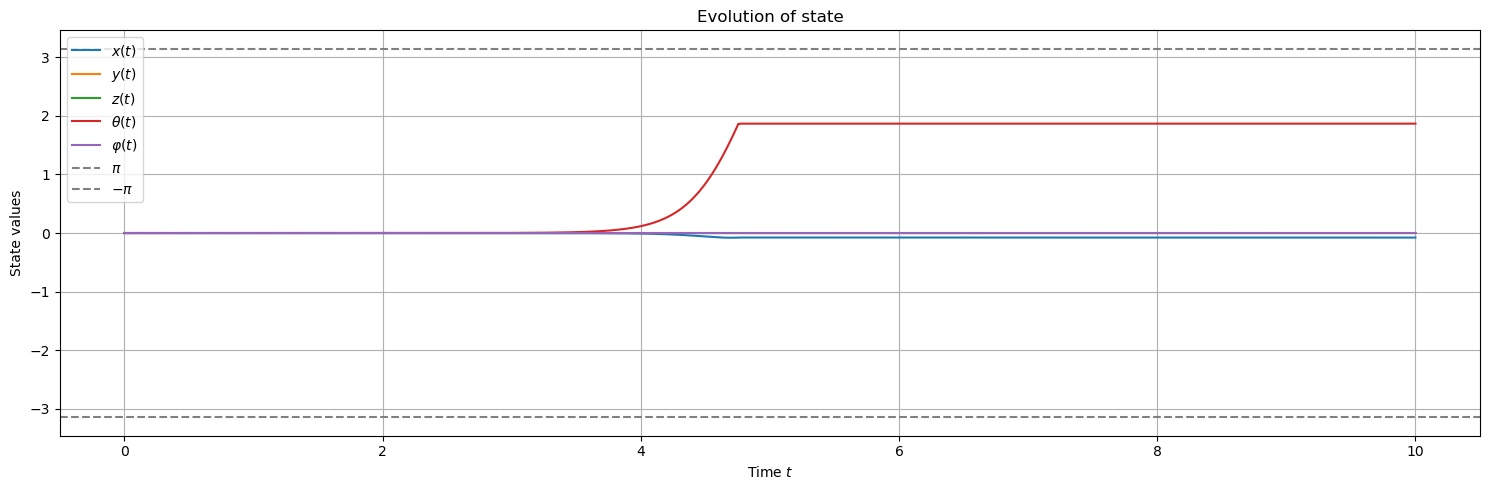

In [240]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_x, label=r'$x(t)$')
plt.plot(sol_t, sol_y, label=r'$y(t)$')
plt.plot(sol_t, sol_z, label=r'$z(t)$')
plt.plot(sol_t, sol_theta, label=r'$\theta(t)$')
plt.plot(sol_t, sol_phi, label=r'$\varphi(t)$')

plt.axhline(y=np.pi, linestyle='--', color='gray', label=r'$\pi$')
plt.axhline(y=-np.pi, linestyle='--', color='gray', label=r'$-\pi$')

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of state')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

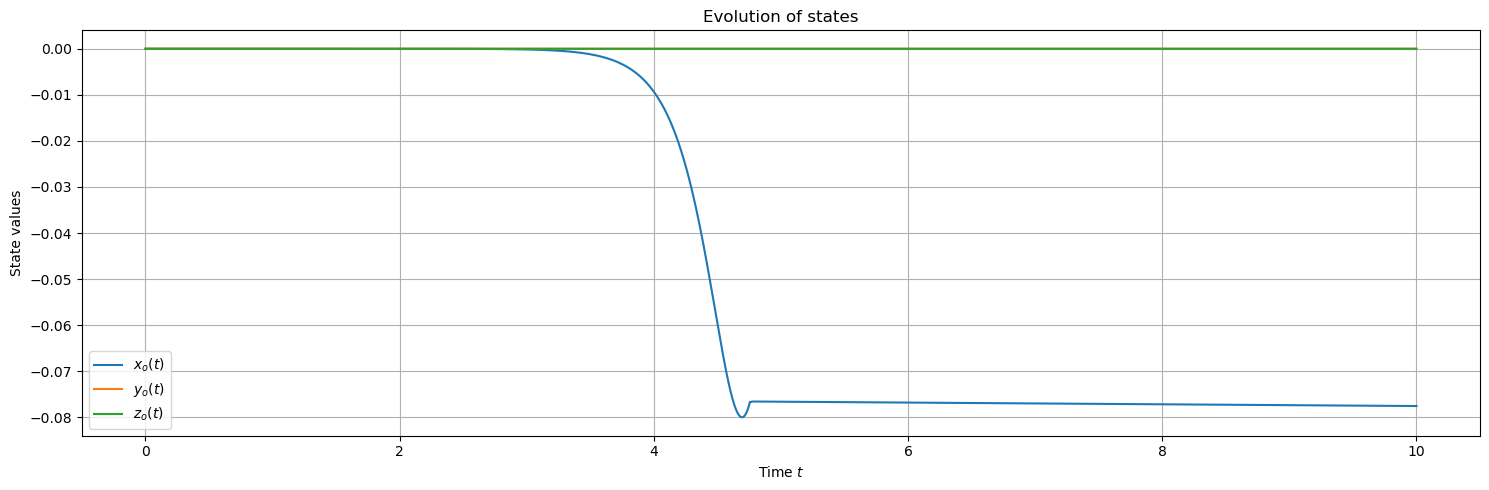

In [241]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xo, label=[r'$x_o(t)$', r'$y_o(t)$', r'$z_o(t)$'])
# plt.plot(sol_t, sol_x, label=r'$x(t)$')

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

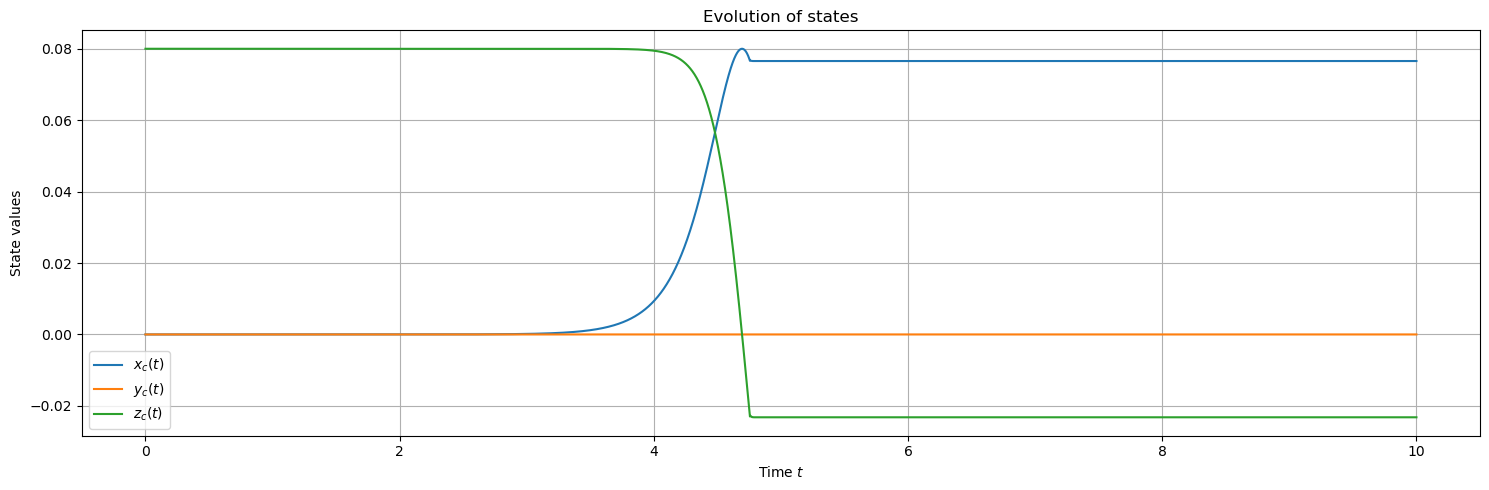

In [242]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xc - sol_xo, label=[r'$x_c(t)$', r'$y_c(t)$', r'$z_c(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

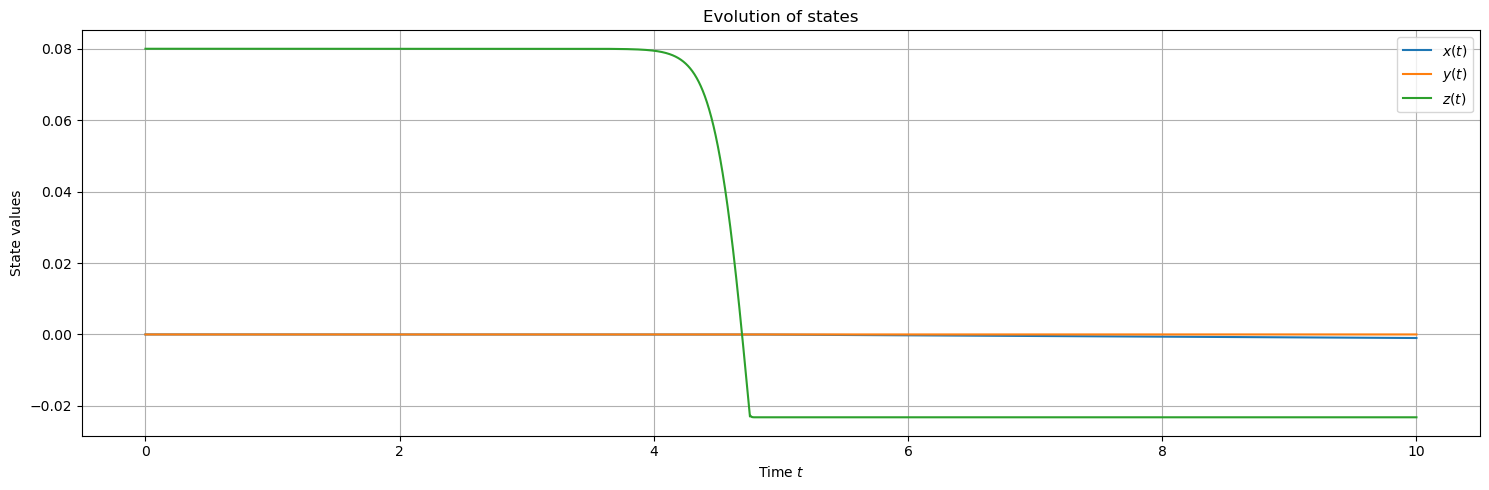

In [243]:
plt.figure(figsize=(15, 5))

plt.plot(sol_t, sol_xc, label=[r'$x(t)$', r'$y(t)$', r'$z(t)$'])

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('Evolution of states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()